In [1]:
def Daniel_Data_Loader():
    # Daniel loads his data / If we want different data we do that here
    # For a encoder decoder model we will need 3 inputs:
    # encoder input, decoder support, blend factor (for how much we want to do teacher forcing)
    from load_DER_data import load_dataset
    raw_data = load_dataset()

    from datasets_utils import datasets_from_data
    inp, ev, pdf = datasets_from_data(raw_data,
                                      sw_len_samples=int(7*24*(60/5)),
                                      fc_len_samples=int(1*25*(60/5)),
                                      fc_steps=25,
                                      fc_tiles=33,
                                      target_dims=[0,1,2,3,4],
                                      plot=True,
                                     steps_to_new_sample=15)
    import numpy as np
    ev = np.expand_dims(ev, axis=-1)
    inp_train = inp[:int(0.8*inp.shape[0]),:,:]
    inp_test = inp[int(0.8*inp.shape[0]):,:,:]
    pdf_train = pdf[:int(0.8*inp.shape[0]),1:,:]
    pdf_test = pdf[int(0.8*inp.shape[0]):,1:,:]
    ev_train = ev[:int(0.8*inp.shape[0]),1:,:]
    ev_test = ev[int(0.8*inp.shape[0]):,1:,:]
    ev_teacher_train = ev[:int(0.8*inp.shape[0]),:-1,:]
    ev_teacher_test = ev[int(0.8*inp.shape[0]):,:-1,:]

    blend_factor = np.expand_dims(np.ones(inp_train.shape[0]), axis=-1)
    print(blend_factor.shape)



    print('The training set has an input data shape of ', 
          inp_train.shape,
          'to expected value targets of ',
         ev_train.shape,
         'or alternatively pdf_targets of ',
         pdf_train.shape)
    print('-----------------------------------------------')
    print('The testing set has an input data shape of ', 
          inp_test.shape,
          'to expected value targets of ',
         pdf_test.shape,
         'or alternatively pdf_targets of ',
         ev_test.shape)
    
    return inp_train, inp_test, ev_train, ev_test, ev_teacher_train, ev_teacher_test, blend_factor


In [2]:
# Recommending Liza to put her dataloader here, so we can work in the same document maybe xD


In [3]:
import tensorflow as tf
from tensorflow import keras
keras.backend.clear_session() # make sure we are working clean

#ToDo: figure out a proper naming scheme for layers, all caps in words might be nice
# ToDo: figure out if we really are doing dropout ONLY during training, or if we are also doing dropout during inference...

# Application of Zopneout on hidden encoder & decoder states.
# ToDo: Liza pls comment properly :-)
class ZoneoutWrapper(tf.keras.layers.Layer):
    def __init__(self, layer, zoneout_prob):
        super(ZoneoutWrapper, self).__init__()
        self.zoneout_prob = zoneout_prob
        self._layer = layer
    
    def call(self, inputs, initial_state):
        inputs = tf.nn.dropout(inputs, self.zoneout_prob) # add feed forward dropout (i think the performance is better)
        output, state_h, state_c = self._layer(inputs, initial_state)
        state_h = (1-self.zoneout_prob)*tf.nn.dropout((state_h - initial_state[0]), self.zoneout_prob) + state_h
        state_c = (1-self.zoneout_prob)*tf.nn.dropout((state_c - initial_state[1]), self.zoneout_prob) + state_c
        
        return output, state_h, state_c

# Application of feed-forward & recurrent dropout on encoder & decoder hidden states.
# ToDo: Liza pls comment properly :-)
class DropoutWrapper(tf.keras.layers.Layer):
    def __init__(self, layer, zoneout_prob):
        super(ZoneoutWrapper, self).__init__()
        self.zoneout_prob = zoneout_prob
        self._layer = layer
    
    def call(self, inputs, initial_state):
        inputs = tf.nn.dropout(inputs, self.zoneout_prob)
        output, state_h, state_c = self._layer(inputs, initial_state)
        state_h = tf.nn.dropout(state_h, self.zoneout_prob)
        state_c = tf.nn.dropout(state_c, self.zoneout_prob)
        inputs = tf.nn.dropout(inputs, self.zoneout_prob)
        
        return output, state_h, state_c
    
# this builds the wrapper class for the multilayer LSTM
# in addition to the multiple LSTM layers it adds
# dropout
# layer norm (or maybe recurrent layer norm, whatever feels best)
# inits are the num_layers, num_units per layer and dropout rate
# call needs the inputs and the initial state
# it gives the outputs of all RNN layers (or should it be just one?)
# and the states at the last step
class MultiLayer_LSTM(tf.keras.layers.Layer):
    def __init__(self, num_layers, num_units, use_dropout=True, dropout_rate=0.0, use_norm=True):
        super(MultiLayer_LSTM, self).__init__()

        self.num_layers = num_layers # simple, just save all the things we might need
        self.num_units = num_units
        self.dropout_rate = dropout_rate
        self.use_dropout = use_dropout
        self.use_norm = use_norm
        
        self.LSTM = [] # Multiple layers work easiest as a list of layers, so here we start
        self.norm = []
        for layer in range(self.num_layers):
            # get one LSTM layer per layer we speciefied, with the units we need
            one_LSTM_layer = tf.keras.layers.LSTM(self.num_units,
                                                 return_sequences=True,
                                                 return_state=True,
                                                 recurrent_initializer='glorot_uniform')
            
            # if it is the first layer of we do not want to use dropout, we won't
            # otherwise add the zoneout wrapper
            
            if layer == 0 or self.use_dropout==False:
                self.LSTM.append(one_LSTM_layer)
            else:
                self.LSTM.append(ZoneoutWrapper(one_LSTM_layer, zoneout_prob=self.dropout_rate))
            
            if self.use_norm:
                self.norm.append(tf.keras.layers.LayerNormalization(axis=-1,
                                                                   center=True,
                                                                   scale=True))

    def call(self, inputs, initial_states):
        
        if initial_states is None:  # ToDo: think about noisy initialization?
            initial_states = []
            for layer in range(self.num_layers):
                state_h = tf.zeros([tf.shape(inputs)[0], self.num_units])
                state_c = tf.zeros([tf.shape(inputs)[0], self.num_units])
                initial_states.append([state_h, state_c])
        
        all_out = [] #again, we are working with lists, so we might just as well do the same for the outputs
        states = []
        
        out = inputs #just a simple trick to prevent usage of one if_else loop for the first layer    
        for layer in range(self.num_layers):
            out, state_h, state_c = self.LSTM[layer](out, initial_state=initial_states[layer])
            if self.use_norm:
                out = self.norm[layer](out)
            all_out.append(out)
            states.append([state_h, state_c])
            
        return all_out, states

# This builds the Encoder_LSTM
# basically just a simple pseudowrapper for the MultiLayer_LSTM layer
# ToDO: add a projection layer, that might be important for the attention mechs later on
# this will reduce the size of attention needed :-)
class encoder_LSTM(tf.keras.layers.Layer):
    def __init__(self, num_layers, num_units, use_dropout=True, dropout_rate=0.0):
        super(encoder_LSTM, self).__init__()
        self.layers = num_layers
        self.units = num_units
        self.encoder = MultiLayer_LSTM(num_layers, num_units, use_dropout, dropout_rate)
    
    def call(self, encoder_inputs, initial_states=None):
        encoder_outputs, encoder_states = self.encoder(encoder_inputs, initial_states=initial_states)
        
        return encoder_outputs, encoder_states, 

# this builds the decoder LSTM
# using the MultiLayer_LSTM, all we really need to do is do stepwise unrolling
# the decoder needs additional inputs compared to the decoder ...
class decoder_LSTM(tf.keras.layers.Layer):
    def __init__(self, num_layers, num_units, out_shape, use_dropout=True, dropout_rate=0.0):
        super(decoder_LSTM, self).__init__()
        self.layers = num_layers
        self.units = num_units
        self.out_shape = out_shape
        
        self.reshape_to_1ts = tf.keras.layers.Reshape((1,self.out_shape[1])) # Keras is finicky with dimensions, this is to make sure the dim is specified
        self.concat_timestep = tf.keras.layers.Concatenate(axis=1) # concatenates the timeteps together
        
        self.decoder = MultiLayer_LSTM(num_layers, num_units, use_dropout, dropout_rate)
        
        self.decoder_wrap = []
        if self.units > 512:
            self.decoder_wrap.append(tf.keras.layers.Dense(units=256,
                                                           activation='relu'))
        self.decoder_wrap.append(tf.keras.layers.Dense(units=self.out_shape[1]))

    def call(self, decoder_inputs, initial_states, blend_factor_input):
        
        
        
        blend_factor = self.reshape_to_1ts(blend_factor_input) #because, otherwise keras will be acting wierd as the decoder_output is (1,1) and this would be (1)
        
        dec_states_t = initial_states #get the initial states for the first timestep
                                          
        for t in range(self.out_shape[0]): #for loop over all timesteps
            
            # determine the input to the decoder
            target_support_t = self.reshape_to_1ts(decoder_inputs[:,t,:]) # slice a timestep of the support
            if t == 0: # if no previous output we cannot blend
                dec_in_t = target_support_t
            else: # otherwise blend as desired
                dec_in_t = (1.0-blend_factor)*dec_out_t + blend_factor*target_support_t
            
            # use the decodeer_LSTM
            output_decoder_LSTM, dec_states_t = self.decoder(dec_in_t, initial_states=dec_states_t)

            # do the output projection
            dec_out_t_not_projected = output_decoder_LSTM[-1] #get the lat layer output of the decoder
            for layer in range(len(self.decoder_wrap)):
                dec_out_t_not_projected = self.decoder_wrap[layer](dec_out_t_not_projected)                                                                                   
            dec_out_t = self.reshape_to_1ts(dec_out_t_not_projected)
            
            # construct the output time-series
            if t == 0:
                decoder_output = dec_out_t
            else: #else we append
                decoder_output = self.concat_timestep([decoder_output, dec_out_t])
                                                                                                                    
        return decoder_output

# this builds a basic encoder decoder model with:
# encoder layers / units == decoder layers / units
# output shape is the desired shape of the output [timesteps, dimensions]
# input shape is the supplied encoder input shape [inp_tmesteps, input_dimensions]
# the model will have three inputs:
# the encoder input [inp_tmesteps, input_dimensions]
# the decoder input  [timesteps, dimensions](for teacher forcing and blending to non-teacher forcing)
# the blend factor between decoder model output and real target out
# the model will have one output
# output [timesteps, dimensions]
def build_model(E_D_layers, E_D_units, in_shape, out_shape, dropout_rate=0.3):
    layers = E_D_layers # remember units and layers
    units = E_D_units
    #   Encoder
    encoder_inputs = tf.keras.layers.Input(shape=(inp_train.shape[1], inp_train.shape[2]))
    encoder = encoder_LSTM(layers, units, use_dropout=True, dropout_rate=dropout_rate)
    # ------------------------------------------------------------------------------------------
    #   Decoder
    decoder_inputs = tf.keras.layers.Input(shape=(out_shape[0], out_shape[1]))
    blend_factor_input = tf.keras.layers.Input(shape=(1))
    decoder = decoder_LSTM(layers, units, use_dropout=True, dropout_rate=dropout_rate, out_shape=out_shape)
    # ------------------------------------------------------------------------------------------
    encoder_outputs, encoder_states = encoder(encoder_inputs)
    decoder_output = decoder(decoder_inputs, initial_states=encoder_states, blend_factor_input=blend_factor_input)
    
    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = tf.keras.Model([encoder_inputs, decoder_inputs, blend_factor_input], decoder_output)
    return model

fetching NWP...
Simulations start at:  2016-01-01 18:00:00
Sample time of Sims is:  0:05:00
Sample time of simulation: 0:05:00
missing  503  samples from  2016-12-31 00:00:00 to  2017-01-01 18:00:00
Setting flags for those datapoints to 1
(649, 12) (503, 13)
missing  1079  samples from  2017-03-23 00:00:00 to  2017-03-26 18:00:00
Setting flags for those datapoints to 1
(649, 12) (1079, 13)
replacing the fauly values with the mean of the array
fetched NWP ... now fetching PV Data
Loading generation data from  2016-01-0117:00:00  to  2017-12-3117:05:00
fetched PV ... now concatenating


c:\users\danielcmaz\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
c:\users\danielcmaz\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


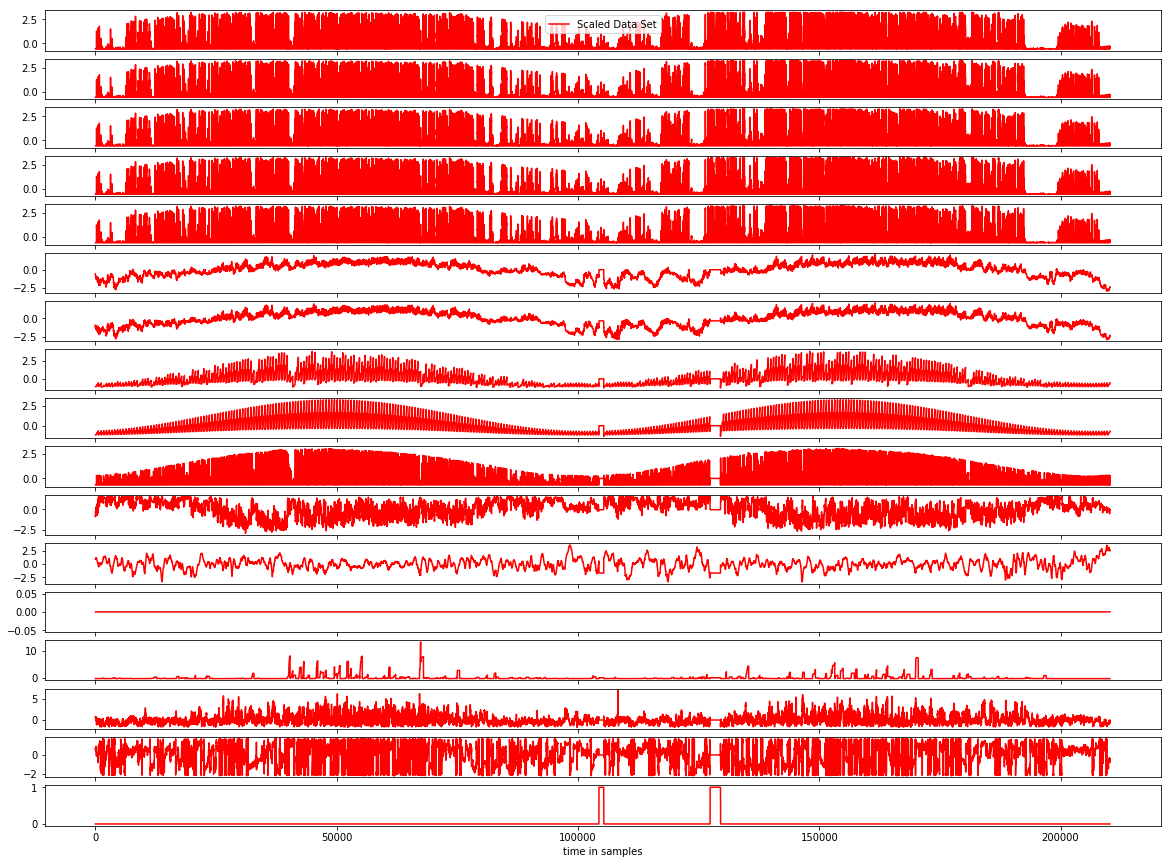

0 percent converted
9 percent converted
19 percent converted
29 percent converted
39 percent converted
49 percent converted
59 percent converted
69 percent converted
79 percent converted
89 percent converted
(10704, 1)
The training set has an input data shape of  (10704, 2016, 16) to expected value targets of  (10704, 24, 1) or alternatively pdf_targets of  (10704, 24, 33)
-----------------------------------------------
The testing set has an input data shape of  (2677, 2016, 16) to expected value targets of  (2677, 24, 33) or alternatively pdf_targets of  (2677, 24, 1)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 24, 1)]      0                                            
__________________________________________________________________________________________________
input_1 (Inp

In [8]:
# dumb variation of the encoder decoder
# this will be using teacher forcing
import tensorflow as tf
from tensorflow import keras
keras.backend.clear_session() # make sure we are working clean

inp_train, inp_test, ev_train, ev_test, ev_teacher_train, ev_teacher_test, blend_factor = Daniel_Data_Loader()

E_D_layers = 3
E_D_units = 300
out_shape = [ev_train.shape[1], ev_train.shape[2]]
in_shape = [inp_train.shape[1], inp_train.shape[2]]
model = build_model(E_D_layers, E_D_units, in_shape, out_shape) #get a E_D_model

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3) # set optimizers, metrics and loss
loss = tf.keras.losses.MeanSquaredError()
metrics = [tf.keras.metrics.MeanAbsolutePercentageError()]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics) #compile, print summary
model.summary()

#ToDo: insert loop that adjusts the blend_factor from 1 to 0 depending on how the validation loss develops
hist_loss = []
hist_val_loss = []
hist_metric = []
hist_val_metric = []
decrease = 0
epoch  = 0
best_val_loss = 1e6
prev_val_loss = 1e6

while decrease < 6:
    history = model.fit(x=[inp_train, ev_teacher_train, blend_factor], #train for a given set of epochs, look at history
              y=ev_train,
              batch_size=32,
              epochs=1,
              validation_split=0.2)
    
    val_metric = history.history['val_mean_absolute_percentage_error']
    val_loss = history.history['val_loss'][0]
    
    if best_val_loss > val_loss: #if we see no increase in absolute performance, increase the death counter
        decrease = 0 # reset the death counter
        best_val_loss = val_loss
        best_wts = model.get_weights()
        print('saving a new model')
    else:
        decrease += 1

        
    if prev_val_loss < val_loss: # if we have no relative increase in quality towards the previous iteration
        # then decrease the blend factor
        blend_factor = 0.85*blend_factor
        print('lowering blend factor')
    
    epoch += 1
    prev_val_loss = val_loss
    
    hist_loss.append(history.history['loss'])
    hist_val_loss.append(history.history['val_loss'])
    hist_metric.append(history.history['mean_absolute_percentage_error'])
    hist_val_metric.append(history.history['val_mean_absolute_percentage_error'])
model.set_weights(best_wts)

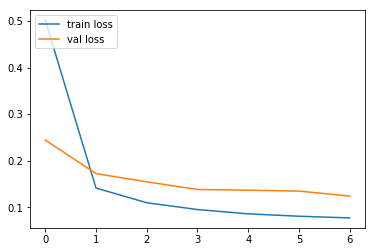

In [5]:
import pylab 

pylab.plot(hist_loss, label="train loss")
pylab.plot(hist_val_loss, label="val loss")
pylab.legend(loc='upper left')
pylab.show()



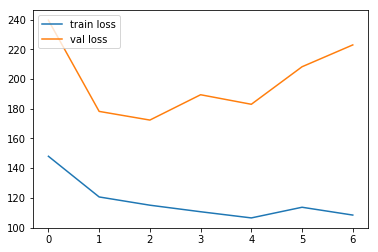

In [6]:
pylab.plot(hist_metric, label="train loss")
pylab.plot(hist_val_metric, label="val loss")
pylab.legend(loc='upper left')
pylab.show()

In [7]:
pred = model.predict(x=[inp_test, ev_teacher_test, blend_factor])

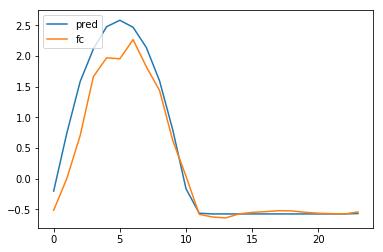

In [11]:
import random 
random_factor = random.randint(0, pred.shape[0])

pylab.plot(ev_test[random_factor,:], label="pred")
pylab.plot(pred[random_factor,:, 0], label="fc")
pylab.legend(loc='upper left')
pylab.show()